### Data preparation and reading ticks

In [ ]:
import pandas as pd
from typing import List, Dict

def load_tick_data(file_path: str) -> pd.DataFrame:
    """
    Load tick data from a CSV file, parse dates and times, and set a datetime index.
    
    Parameters:
    file_path (str): The path to the CSV file.
    
    Returns:
    pd.DataFrame: A DataFrame with a datetime index and tick data.
    """
    # Define column names based on the file structure
    column_names: List[str] = ['date', 'time', 'bid', 'ask', 'last', 'volume', 'flags']
    
    # Read the CSV file, specifying the tab separator and skipping the header
    df = pd.read_csv(file_path, sep='\t', header=0, names=column_names, skiprows=1)
    
    # Convert date and time columns to a single datetime column
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    
    # Set the new datetime column as the index
    df.set_index('datetime', inplace=True)
    
    # Drop the original date and time columns
    df.drop(['date', 'time'], axis=1, inplace=True)
    
    return df

# Path to the data file
file_path: str = "/home/edocame/Desktop/data_python/03_BID_ASK_DATA/eurchf 1year.csv"

# Load the data using the function
tick_data = load_tick_data(file_path)

# Display the first few rows of the DataFrame
print(tick_data.head())


## Main logic

In [1]:
import pandas as pd
from numba import njit
tick_data = pd.read_parquet('/home/edocame/Desktop/data_python/03_BID_ASK_DATA/eurchf 1year.parquet')

In [2]:
def bollingerbands(data: pd.DataFrame, window: int = 20, num_std_dev: float = 2) -> pd.DataFrame:
    """
    Calculate Bollinger Bands and the middle band (moving average) for a given DataFrame.

    Parameters:
    data (pd.DataFrame): DataFrame containing financial data with a 'midprice' column.
    window (int): The number of periods to use for the moving average and standard deviation.
    num_std_dev (float): The number of standard deviations to use for the upper and lower bands.

    Returns:
    pd.DataFrame: DataFrame with Bollinger Bands and middle band added as columns.
    """
    # Calculate the rolling mean and standard deviation
    rolling_mean = data['midprice'].rolling(window=window).mean()
    rolling_std = data['midprice'].rolling(window=window).std()

    # Calculate the upper and lower Bollinger Bands
    data['upper_band'] = rolling_mean + (rolling_std * num_std_dev)
    data['lower_band'] = rolling_mean - (rolling_std * num_std_dev)
    # Calculate the middle band (moving average)
    data['middle_band'] = rolling_mean

    return data

In [9]:
# Resample tick_data to 1-minute intervals, taking the first non-null bid and ask of each minute
minute_sample = tick_data.resample('1T').agg({'bid': 'first', 'ask': 'first'})
minute_sample['midprice'] = (minute_sample['bid'] + minute_sample['ask']) / 2

# Rimuovi le righe con valori NaN prima del calcolo delle Bollinger Bands
minute_sample_clean = minute_sample.dropna()
print(f"Righe prima della pulizia: {len(minute_sample)}")
print(f"Righe dopo rimozione NaN: {len(minute_sample_clean)}")

# Usa una finestra più ragionevole - 20 minuti invece di 1440
window = 1440  # Finestra per le Bollinger Bands
num_std_dev = 1.0  # Numero di deviazioni standard

# Verifica che abbiamo abbastanza dati per la finestra scelta
if len(minute_sample_clean) >= window:
    # Aggiungi le Bollinger Bands al DataFrame
    minute_sample_with_bands = bollingerbands(minute_sample_clean.copy(), window=window, num_std_dev=num_std_dev)
    
    # Filtra il DataFrame per includere solo le righe dove tutte le colonne sono valide
    complete_data = minute_sample_with_bands.dropna()
    
    print(f"Righe dopo calcolo Bollinger Bands: {len(complete_data)}")
    print(f"Prime 3 righe del DataFrame unificato:")
    print(complete_data.head(3))
    print(f"Colonne disponibili: {complete_data.columns.tolist()}")
else:
    print(f"ERRORE: Non abbastanza dati per la finestra scelta. Dati disponibili: {len(minute_sample_clean)}, finestra richiesta: {window}")
    complete_data = None

/tmp/ipykernel_43161/2423799548.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_sample = tick_data.resample('1T').agg({'bid': 'first', 'ask': 'first'})


Righe prima della pulizia: 524801
Righe dopo rimozione NaN: 368551
Righe dopo calcolo Bollinger Bands: 367112
Prime 3 righe del DataFrame unificato:
                         bid      ask  midprice  upper_band  lower_band  \
datetime                                                                  
2024-07-15 12:28:00  0.97547  0.97550  0.975485    0.975924    0.974852   
2024-07-15 12:29:00  0.97541  0.97544  0.975425    0.975924    0.974852   
2024-07-15 12:30:00  0.97541  0.97544  0.975425    0.975924    0.974852   

                     middle_band  
datetime                          
2024-07-15 12:28:00     0.975388  
2024-07-15 12:29:00     0.975388  
2024-07-15 12:30:00     0.975388  
Colonne disponibili: ['bid', 'ask', 'midprice', 'upper_band', 'lower_band', 'middle_band']


In [10]:
# Debug: Analizziamo i dati per capire il problema
print("=== ANALISI DEI DATI ===")
print(f"Righe in minute_sample: {len(minute_sample)}")
print(f"Valori NaN in minute_sample:")
print(minute_sample.isnull().sum())
print(f"\nPrimi 5 valori di minute_sample:")
print(minute_sample.head())

# Proviamo con una finestra più piccola per test
test_window = 20
print(f"\n=== TEST CON FINESTRA PIÙ PICCOLA (window={test_window}) ===")
minute_sample_test = bollingerbands(minute_sample.copy(), window=test_window, num_std_dev=1.0)
print(f"Righe dopo calcolo Bollinger Bands: {len(minute_sample_test)}")
print(f"Valori NaN dopo Bollinger Bands:")
print(minute_sample_test.isnull().sum())

complete_data_test = minute_sample_test.dropna()
print(f"Righe dopo dropna(): {len(complete_data_test)}")

if len(complete_data_test) > 0:
    print(f"Prime 3 righe del DataFrame di test:")
    print(complete_data_test.head(3))
else:
    print("Anche con finestra piccola, nessun dato valido!")

=== ANALISI DEI DATI ===
Righe in minute_sample: 524801
Valori NaN in minute_sample:
bid         155745
ask         156250
midprice    156250
dtype: int64

Primi 5 valori di minute_sample:
                         bid      ask  midprice
datetime                                       
2024-07-12 12:18:00  0.97548  0.97548   0.97548
2024-07-12 12:19:00  0.97553  0.97555   0.97554
2024-07-12 12:20:00  0.97558  0.97560   0.97559
2024-07-12 12:21:00  0.97559  0.97561   0.97560
2024-07-12 12:22:00  0.97560  0.97562   0.97561

=== TEST CON FINESTRA PIÙ PICCOLA (window=20) ===
Righe dopo calcolo Bollinger Bands: 524801
Valori NaN dopo Bollinger Bands:
bid            155745
ask            156250
midprice       156250
upper_band     167662
lower_band     167662
middle_band    167662
dtype: int64
Righe dopo dropna(): 357139
Prime 3 righe del DataFrame di test:
                         bid      ask  midprice  upper_band  lower_band  \
datetime                                                       

In [11]:
@njit
def backtest_core(bid, ask, midprice, upper_band, lower_band, middle_band):
    """
    Core backtesting logic implemented in Numba for performance.
    Uses precomputed middle_band for efficiency.
    Profits are calculated in pips.

    Logic:
    - If the midprice crosses above the upper band, it indicates a sell signal.
    - If a short is opened, close at the middle band when midprice crosses below it.
    - If the midprice crosses below the lower band, it indicates a buy signal.
    - If a long is opened, close at the middle band when midprice crosses above it.

    Trades are executed at the next minute's ask/bid price.
    """
    n = len(midprice)
    trades = []
    position = 0  # 0 = flat, 1 = long, -1 = short
    entry_idx = -1
    entry_price = 0.0

    for i in range(1, n - 1):
        # Entry logic
        if position == 0:
            # Long entry: cross below lower band
            if midprice[i-1] > lower_band[i-1] and midprice[i] < lower_band[i]:
                position = 1
                entry_idx = i + 1  # Enter at next bar
                if entry_idx < n:
                    entry_price = ask[entry_idx]  # Buy at ask
            # Short entry: cross above upper band
            elif midprice[i-1] < upper_band[i-1] and midprice[i] > upper_band[i]:
                position = -1
                entry_idx = i + 1  # Enter at next bar
                if entry_idx < n:
                    entry_price = bid[entry_idx]  # Sell at bid

        # Exit logic
        elif position == 1:
            # Exit long: cross above middle band (mean)
            if midprice[i-1] < middle_band[i-1] and midprice[i] > middle_band[i]:
                exit_idx = i + 1
                if exit_idx < n:
                    exit_price = bid[exit_idx]  # Sell at bid
                    pnl = (exit_price - entry_price) * 10000  # PnL in pips
                    trades.append((pnl, 1, entry_idx, exit_idx))
                position = 0
                entry_idx = -1
                entry_price = 0.0

        elif position == -1:
            # Exit short: cross below middle band (mean)
            if midprice[i-1] > middle_band[i-1] and midprice[i] < middle_band[i]:
                exit_idx = i + 1
                if exit_idx < n:
                    exit_price = ask[exit_idx]  # Buy at ask
                    pnl = (entry_price - exit_price) * 10000  # PnL in pips
                    trades.append((pnl, -1, entry_idx, exit_idx))
                position = 0
                entry_idx = -1
                entry_price = 0.0

    # Handle open position at the end (force close at last available price)
    if position == 1 and entry_idx < n:
        exit_price = bid[n-1]
        pnl = (exit_price - entry_price) * 10000
        trades.append((pnl, 1, entry_idx, n-1))
    elif position == -1 and entry_idx < n:
        exit_price = ask[n-1]
        pnl = (entry_price - exit_price) * 10000
        trades.append((pnl, -1, entry_idx, n-1))

    return trades

In [12]:
class Backtest:
    """
    Backtest class for running a Bollinger Bands trading strategy on financial data.
    
    Attributes:
        data (pd.DataFrame): The input financial data with all required columns already synchronized.
    """

    def __init__(self, data: pd.DataFrame) -> None:
        """
        Initialize the Backtest class with the provided unified and synchronized data.

        Parameters:
            data (pd.DataFrame): DataFrame containing financial data with 'bid', 'ask', 'midprice', 
                                'upper_band', 'lower_band', and 'middle_band' columns.
        """
        self.data = data
        
        # Verifica che tutte le colonne necessarie siano presenti
        required_columns = ['bid', 'ask', 'midprice', 'upper_band', 'lower_band', 'middle_band']
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    def run(self) -> pd.DataFrame:
        """
        Run the backtest on the provided unified data.

        Returns:
            pd.DataFrame: The input DataFrame (already contains all necessary data).
        Raises:
            ValueError: If there is not enough data to run the backtest.
        """
        # Verifica che ci siano dati sufficienti per il backtest
        if len(self.data) < 3:
            raise ValueError(
                f"Not enough data to run backtest: "
                f"need at least 3 rows, got {len(self.data)}."
            )

        # Converti le colonne del DataFrame in numpy arrays per compatibilità con numba
        bid = self.data['bid'].to_numpy()
        ask = self.data['ask'].to_numpy()
        midprice = self.data['midprice'].to_numpy()
        upper_band = self.data['upper_band'].to_numpy()
        lower_band = self.data['lower_band'].to_numpy()
        middle_band = self.data['middle_band'].to_numpy()

        # Esegui la logica principale del backtest
        results = backtest_core(bid, ask, midprice, upper_band, lower_band, middle_band)

        # Salva i risultati nella classe
        self.results = results

        return self.data

In [13]:
# Esegui il backtest solo se abbiamo dati validi
if complete_data is not None and len(complete_data) > 0:
    # Esegui il backtest utilizzando la classe Backtest con il DataFrame unificato
    backtester = Backtest(complete_data)
    valid_data = backtester.run()
    
    # Estrai i risultati dei trade
    results = backtester.results
    
    # Riepilogo dei risultati
    num_trades = len(results)
    pnl_totale = sum([trade[0] for trade in results])
    pnl_medio = pnl_totale / num_trades if num_trades > 0 else 0
    
    print(f"Numero di trade: {num_trades}")
    print(f"PnL totale (pips): {pnl_totale:.2f}")
    print(f"PnL medio per trade (pips): {pnl_medio:.2f}")
    
    # Mostra i primi 5 trade come esempio
    if num_trades > 0:
        print("Primi 5 trade (PnL, Direzione, Entry idx, Exit idx):")
        for trade in results[:5]:
            print(trade)
    else:
        print("Nessun trade eseguito.")
else:
    print("ERRORE: Non è possibile eseguire il backtest - dati insufficienti.")
    results = []
    num_trades = 0

Numero di trade: 638
PnL totale (pips): 800.20
PnL medio per trade (pips): 1.25
Primi 5 trade (PnL, Direzione, Entry idx, Exit idx):
(2.00000000000089, -1, 207, 377)
(-2.4000000000001798, -1, 429, 673)
(5.499999999999394, 1, 1096, 1307)
(3.9000000000000146, -1, 1400, 1506)
(4.100000000000215, -1, 1515, 1589)


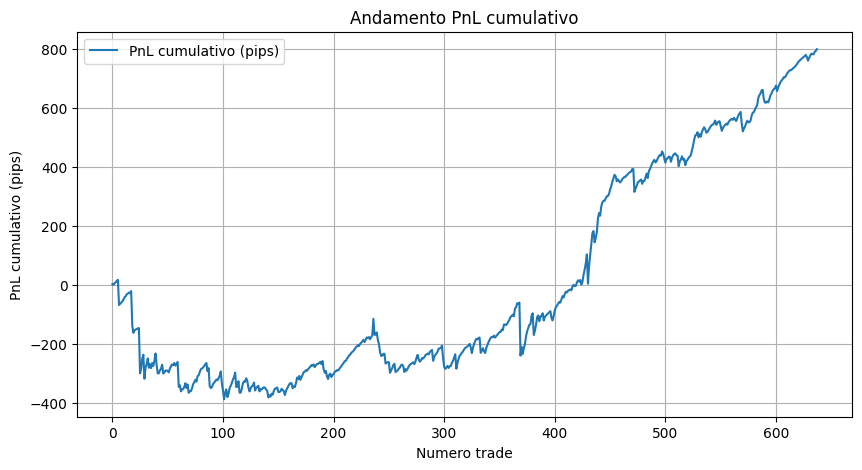

,PnL,Direzione,Entry_idx,Exit_idx,PnL_cumulativo
0,2.0,-1,207,377,2.0
1,-2.4,-1,429,673,-0.4
2,5.5,1,1096,1307,5.1
3,3.9,-1,1400,1506,9.0
4,4.1,-1,1515,1589,13.1
5,4.0,1,1596,1617,17.1
6,-85.8,1,1634,4405,-68.7
7,3.9,1,4426,4613,-64.8
8,4.3,-1,4639,4773,-60.5
9,3.7,-1,4809,5407,-56.8


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Se ci sono trade, crea DataFrame dei risultati
if num_trades > 0:
    trades_df = pd.DataFrame(results, columns=["PnL", "Direzione", "Entry_idx", "Exit_idx"])
    trades_df["PnL_cumulativo"] = trades_df["PnL"].cumsum()
    
    # Grafico del PnL cumulativo
    plt.figure(figsize=(10, 5))
    plt.plot(trades_df["PnL_cumulativo"], label="PnL cumulativo (pips)")
    plt.xlabel("Numero trade")
    plt.ylabel("PnL cumulativo (pips)")
    plt.title("Andamento PnL cumulativo")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Mostra una tabella riassuntiva dei primi 10 trade
    display(trades_df.head(10))
else:
    print("Nessun trade eseguito.")

In [29]:
dft = pd.read_csv('/home/edocame/Desktop/bollingerBands/DATA/eurchf_1440_01.csv',
                  sep='\t', encoding='utf-16')

dft.set_index('<DATE>', inplace=True)


import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=dft.index, y=dft['<BALANCE>'], mode='lines', name='Balance'))
fig.update_layout(title='Balance over time (interactive)', xaxis_title='Date', yaxis_title='Balance', template='plotly_white')
fig.show()

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Controllo se abbiamo risultati di trading da confrontare
if num_trades > 0 and 'results' in locals():
    print("=== CONFRONTO PnL BACKTEST vs BALANCE REALE ===")
    
    # Leggi il file balance
    dft = pd.read_csv('/home/edocame/Desktop/bollingerBands/DATA/eurchf_1440_01.csv',
                      sep='\t', encoding='utf-16')
    
    # Converti l'indice in datetime se non lo è già
    dft['<DATE>'] = pd.to_datetime(dft['<DATE>'])
    dft.set_index('<DATE>', inplace=True)
    
    # Crea DataFrame per i risultati del backtest con timestamp
    trades_df = pd.DataFrame(results, columns=["PnL", "Direzione", "Entry_idx", "Exit_idx"])
    trades_df["PnL_cumulativo"] = trades_df["PnL"].cumsum()
    
    # Associa i timestamp ai trade utilizzando l'indice del DataFrame complete_data
    # Prendi i timestamp degli exit per ogni trade
    timestamps_trades = []
    for trade in results:
        exit_idx = trade[3]  # Exit index
        if exit_idx < len(complete_data):
            timestamp = complete_data.index[exit_idx]
            timestamps_trades.append(timestamp)
        else:
            # Se l'indice è fuori range, usa l'ultimo timestamp disponibile
            timestamp = complete_data.index[-1]
            timestamps_trades.append(timestamp)
    
    trades_df.index = pd.to_datetime(timestamps_trades)
    
    print(f"Periodo backtest: {trades_df.index.min()} - {trades_df.index.max()}")
    print(f"Periodo balance file: {dft.index.min()} - {dft.index.max()}")
    
    # Trova il periodo comune
    start_common = max(trades_df.index.min(), dft.index.min())
    end_common = min(trades_df.index.max(), dft.index.max())
    
    print(f"Periodo comune: {start_common} - {end_common}")
    
    if start_common <= end_common:
        # Filtra entrambi i dataset per il periodo comune
        trades_common = trades_df.loc[start_common:end_common]
        balance_common = dft.loc[start_common:end_common]
        
        # Crea il grafico sovrapposto
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        
        # Aggiungi il PnL cumulativo del backtest
        fig.add_trace(
            go.Scatter(
                x=trades_common.index, 
                y=trades_common['PnL_cumulativo'], 
                mode='lines+markers',
                name='PnL Cumulativo Backtest (pips)',
                line=dict(color='blue', width=2)
            ),
            secondary_y=False,
        )
        
        # Aggiungi il balance del file
        fig.add_trace(
            go.Scatter(
                x=balance_common.index, 
                y=balance_common['<BALANCE>'], 
                mode='lines',
                name='Balance Reale',
                line=dict(color='red', width=2)
            ),
            secondary_y=True,
        )
        
        # Configura gli assi
        fig.update_xaxes(title_text="Data")
        fig.update_yaxes(title_text="PnL Cumulativo (pips)", secondary_y=False)
        fig.update_yaxes(title_text="Balance", secondary_y=True)
        
        fig.update_layout(
            title="Confronto: PnL Backtest vs Balance Reale",
            template='plotly_white',
            hovermode='x unified'
        )
        
        fig.show()
        
        print(f"\\nTrade nel periodo comune: {len(trades_common)}")
        print(f"PnL finale backtest: {trades_common['PnL_cumulativo'].iloc[-1]:.2f} pips")
        print(f"Balance finale reale: {balance_common['<BALANCE>'].iloc[-1]:.2f}")
        
    else:
        print("ERRORE: Non ci sono date in comune tra il backtest e il file balance!")
        
else:
    print("Nessun trade disponibile per il confronto.")

=== CONFRONTO PnL BACKTEST vs BALANCE REALE ===
Periodo backtest: 2024-07-15 18:45:00 - 2025-07-11 19:49:00
Periodo balance file: 2019-01-01 00:00:00 - 2025-07-07 23:59:00
Periodo comune: 2024-07-15 18:45:00 - 2025-07-07 23:59:00


\nTrade nel periodo comune: 623
PnL finale backtest: 763.70 pips
Balance finale reale: 10198.29
